# ETL, data cleaning and exploration
In this notebook I download the data, clean it and perform the spatial joining between pickups and blocks. I conduct as well an exploratory analysis and present some of my findings

## Downloading data
We can use ```gsutil``` to easily download the datasets from google cloud.

In [ ]:
#Downloading data from the bucket
!gsutil cp gs://hiring-test/nyc_cbg_geoms.geojson ./taxi/nyc_cbg_geoms.geojson
!gsutil cp gs://hiring-test/nyc_acs_demographics.csv ./taxi/nyc_acs_demographics.csv
!gsutil cp gs://hiring-test/data.zip ./taxi/data.zip

#unzipping and removing data.zip
!unzip -q taxi/data.zip -d ./taxi/
!rm taxi/data.zip

## Loading data

We are talking here about **5 Gb of data** which needs to be loaded and cleaned. To explore if there are inconcistencies in the data we will take a sample of 1000 taxi rides from each day. Afterwards we will apply the cleaning transformations to the whole dataset.

I notice that most of the files come without headers, excepting the ones referred to the beginning of the month (filename end in 00). We use one of these to get the headers.


In [ ]:
import pandas as pd, numpy as np, os

# we take 1000 samples from each file.

file_with_headers = "./taxi/data/yellow_tripdata_2015-01_00"
headers = pd.read_csv(file_with_headers).columns

path = "./taxi/data"
dataframes = []
for file in os.listdir(path):
    skip_header = 1 if file.endswith("00") else None #if the file has headers then skip first row
    new_df = pd.read_csv(os.path.join(path,file),
                     names = headers,
                     skiprows = skip_header,
                     parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime" ])
    new_df = new_df.sample(1000) 
    dataframes.append(new_df)
df = pd.concat(dataframes)

## Data integrity
When asking pandas for a description of the data sample we can see that there are several inconsistencies.
* The minimum value for the coordinate columns is 0, which means that data is missing for some trips.
* The minimum value for passenger count and trip distance is 0
* The minimum value for the total_amount, mta_tax and extra is negative.
* The maximum value of RateCodeID is 99

It´s clear that the dataset needs to be cleaned up. We run some tests to check whether there are other inconsistencies

In [259]:
description = df.describe()
description.loc["nunique"] =  df.nunique()
description

VendorID  passenger_count  trip_distance  pickup_longitude  \
count    77000.000000     77000.000000   77000.000000      77000.000000   
mean         1.519597         1.685883       6.292705        -72.712812   
std          0.499619         1.342924     936.983000          9.577223   
min          1.000000         0.000000       0.000000        -78.933838   
25%          1.000000         1.000000       1.000000        -73.991936   
50%          2.000000         1.000000       1.700000        -73.981674   
75%          2.000000         2.000000       3.170000        -73.966873   
max          2.000000         6.000000  260003.300000          0.000000   
nunique      2.000000         7.000000    2026.000000      12100.000000   

         pickup_latitude    RateCodeID  dropoff_longitude  dropoff_latitude  \
count       77000.000000  77000.000000       77000.000000      77000.000000   
mean           40.055658      1.044130         -72.752059         40.078151   
std             5.275877      0.909466           9.429211          5.194407   
min             0.000000      1.000000         -90.626572          0.000000   
25%            40.735569      1.000000         -73.991348         40.734074   
50%            40.752766      1.000000         -73.979744         40.753399   
75%            40.767040      1.000000         -73.962448         40.768539   
max            41.095299     99.000000           0.000000         44.675751   
nunique     23858.000000      7.000000       14225.000000      27383.000000   

         payment_type   fare_amount         extra       mta_tax    tip_amount  \
count    77000.000000  77000.000000  77000.000000  77000.000000  77000.000000   
mean         1.386416     12.588316      0.320130      0.497653      1.640938   
std          0.500193     10.895043      0.363066      0.036018      2.474978   
min          1.000000   -130.000000     -1.000000     -0.500000      0.000000   
25%          1.000000      6.500000      0.000000      0.500000      0.000000   
50%          1.000000      9.500000      0.000000      0.500000      1.060000   
75%          2.000000     14.500000      0.500000      0.500000      2.200000   
max          4.000000    499.000000      1.000000      0.500000    150.000000   
nunique      4.000000    297.000000      5.000000      4.000000    979.000000   

         tolls_amount  improvement_surcharge  total_amount  
count    77000.000000           77000.000000  77000.000000  
mean         0.284299               0.294140     15.631125  
std          1.390908               0.041964     13.195421  
min          0.000000              -0.300000   -130.300000  
25%          0.000000               0.300000      8.300000  
50%          0.000000               0.300000     11.760000  
75%          0.000000               0.300000     17.300000  
max         91.000000               0.300000    499.300000  
nunique     77.000000               3.000000   2229.000000

**How many entries with null values are there?**

In [19]:
nans = df.isna().sum()
nans[nans > 0]

improvement_surcharge    3
dtype: int64

**What about the ACS dataset?**

In [284]:
acs = pd.read_csv("./taxi/nyc_acs_demographics.csv", dtype = {"geoid" : np.int64}, index_col=0)
print("Number of negative entries in acs:", (acs.value.values < 0).sum())

Number of negative entries in acs: 0


**Are there any passengers which are dropped off before they are picked up?**

In [263]:
back_in_time = df[df.tpep_pickup_datetime > df.tpep_dropoff_datetime]
back_in_time.head(5)

Are there any passengers which are dropped off before they are picked up?


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
100946         1  2015-01-31 13:16:02   2015-01-31 13:15:26                1   
371782         1  2015-07-05 07:18:48   2015-07-05 07:17:56                1   
422613         1  2015-07-10 16:44:13   2015-07-10 16:43:29                1   

        trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
100946            0.8               0.0              0.0           1   
371782            0.5               0.0              0.0           1   
422613            1.3               0.0              0.0           1   

       store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
100946                  N         -73.992912         40.732269             1   
371782                  N         -73.861290         40.829578             1   
422613                  N         -74.004921         40.729595             1   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
100946          5.5    0.0      0.5        1.26           0.0   
371782          2.5    0.0      0.5        2.00           0.0   
422613          7.0    1.0      0.5        1.76           0.0   

        improvement_surcharge  total_amount  
100946                    0.3          7.56  
371782                    0.3          5.30  
422613                    0.3         10.56

**Are there any amounts related to money with negative value?**

In [281]:
negative_amounts = (df[["tip_amount", "tolls_amount", "total_amount", "fare_amount", "extra", "improvement_surcharge"]] < 0)
print(negative_amounts.any())

tip_amount               False
tolls_amount             False
total_amount              True
fare_amount               True
extra                     True
improvement_surcharge     True
dtype: bool


**Are there any RateCodeIDs with invalid values?**

In [280]:
df["RateCodeID"][df["RateCodeID"].apply(lambda x : x not in [1,2,3,4,5,6])].head()

182788    99
187656    99
367210    99
61838     99
15510     99
Name: RateCodeID, dtype: int64

To get rid of the problematic coordinates (the ones equal to 0 and possibly others) we calculate the square boundaries of the new york geographic area by searching for the highest and lowest coordinates in the geojson file. All taxi trips which fall outside this square should be discarded

In [276]:
import geopandas as gpd
nymap = gpd.read_file("./taxi/nyc_cbg_geoms.geojson")
nymap["geoid"] = nymap["geoid"].astype(np.int64)

ny_coordinates = np.array([ list(polygon.bounds) for polygon in nymap["geometry"].values]).T
min_lon = ny_coordinates[0].min()
max_lon = ny_coordinates[2].max()
min_lat = ny_coordinates[1].min()
max_lat = ny_coordinates[3].max()
print(min_lat, min_lon, max_lat , max_lon)

40.496044 -74.255713 40.918752 -73.686873


In [279]:
out1 = df[(df[["pickup_latitude","dropoff_latitude"]] < min_lat).any(axis = 1)]
out2 = df[(df[["pickup_latitude","dropoff_latitude"]] > max_lat).any(axis = 1)]
out3 = df[(df[["pickup_longitude","dropoff_longitude"]] < min_lon).any(axis = 1)]
out4 = df[(df[["pickup_longitude","dropoff_longitude"]] > max_lon).any(axis = 1)]
pd.concat([out1,out2,out3,out4]).sample(5)

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
142503         2  2015-07-16 18:11:50   2015-07-16 18:17:18                2   
337511         1  2015-04-19 18:21:41   2015-04-19 18:31:53                1   
62313          2  2015-04-13 18:32:51   2015-04-13 18:32:54                5   
113244         1  2015-01-23 17:47:14   2015-01-23 17:58:41                1   
231745         1  2015-04-16 17:58:09   2015-04-16 18:00:08                1   

        trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
142503           0.95          0.000000          0.00000           1   
337511           1.70          0.000000          0.00000           1   
62313            0.00          0.000000          0.00000           1   
113244           1.40        -73.996346         40.76368           1   
231745           0.40          0.000000          0.00000           1   

       store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
142503                  N           0.000000          0.000000             1   
337511                  Y           0.000000          0.000000             2   
62313                   N         -73.781837         40.644772             2   
113244                  N           0.000000          0.000000             1   
231745                  N           0.000000          0.000000             2   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
142503          6.0    1.0      0.5        1.56           0.0   
337511          9.0    0.0      0.5        0.00           0.0   
62313           2.5    1.0      0.5        0.00           0.0   
113244          8.5    1.0      0.5        2.05           0.0   
231745          3.5    1.0      0.5        0.00           0.0   

        improvement_surcharge  total_amount  
142503                    0.3          9.36  
337511                    0.3          9.80  
62313                     0.3          4.30  
113244                    0.3         12.35  
231745                    0.3          5.30

## Merging the taxi and ACS datasets

All thes previous inconsistencies found are being taken care of in the ```TaxiBlockCount``` class where we clean the data and then proceed to merge it with the ACS dataset

To merge both datasets we use the spatial join method available in geopandas, which conveniently allows us to match the pickup coordinates with the blocks defined in the geojson. This is done with the ```spatial_merging``` method  defined in ```TaxiBlockCount``` which I copy below.


In [282]:
def spatial_merging(self, df):

    # We transform df into a geodataframe creating points from the coordinates
    gdf= gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude), crs = {'init': 'epsg:4326'})
    gdf.rename_geometry("pickup_geometry", inplace = True)

    #join gdf with nymap to get the geoid of each pickup by checking to which block belong each row's pickup coordinates
    spatial_join = gpd.sjoin(gdf,self.nymap, how = "inner", op = "within")
    spatial_join.rename(columns = {"geoid": "geoid_pickup"}, inplace = True)
    spatial_join.drop(["index_right"], axis = 1, inplace = True)

    # We merge the dataset with acs first for the pickup locations 
    df_merged = pd.merge(spatial_join, self.acs.add_suffix("_pickup"), left_on="geoid_pickup", right_on= "geoid_pickup")
    # and then for the dropoff locations 
    #df_merged = pd.merge(df_merged, acs.add_suffix("_dropoff"), left_on="geoid_dropoff", right_on= "geoid_dropoff")
    return df_merged

## Computing the number of pickups by block group
We join the datasets by ```geoid_pickup``` and count the number of trips which started at each block group. Then it saves the resulting dataframe to disk. All this is done with the ```compute_pickups``` method in ```TaxiBlockCount``` which I copy below.

In [285]:
def compute_pickups(self,df_merged, file_name, path):
    pickups = pd.Series(data = 1, index = df_merged["geoid_pickup"].values)
    pickup_counts = pickups.groupby(level = 0).count()
    pickup_counts = pd.DataFrame(pickup_counts, columns=["count"])
    pickup_counts.to_csv(os.path.join(path,file_name))

## Processing all the data
We can now use ```TaxiBlockCount``` to process the data from all the files. To take all 77 files at once and try to run the spatial join you need a heck of a computer. A better alternative is to run the spatial join for each file separatedly and combine the results in the end. This has some advantages: 
* You can parallelize the computation of the pickup count for each file since they don't interfere with each other
* You don´t need a super computer.

This way is perfectly scalable for an indefinite amount of data by using cloud services and pyspark (for example).

In order to speed up pandas to load all the data we specify the ```dtypes``` of each column so that it does not need to infer them itself (very expensive for big datasets)

In [ ]:
from run import TaxiBlockCount
taxi = TaxiBlockCount(input_path = "./taxi/", output_path = "./pickup_csvs/")
taxi.process_files()

In [325]:
import os, re
dataframes = []
for file in os.listdir("./pickup_csvs/"):
    if not file.startswith("yellow"): 
        continue
    df = pd.read_csv(os.path.join("./pickup_csvs/",file), index_col = 0)
    year, month, day = re.findall("yellow_tripdata_([0-9]{4})-([0-9]{2})_([0-9]{2})_pickups", file)[0]
    date = f"{year}-{month}-{int(day) + 1}"
    df.rename(columns = {"count": date}, inplace = True)
    dataframes.append(df)

In [326]:
from functools import reduce
df = reduce(lambda  left,right: pd.merge(left,right,left_index= True, right_index= True, how='outer'), dataframes)
df.columns = pd.to_datetime(df.columns, format = "%Y-%m-%d") # we define a datetime index

In [341]:
df.fillna(0, inplace = True)
df.sort_index(axis = 1, inplace = True)
df["total"] = df.values.sum(axis = 1)
df.sort_values(by = "total", ascending = False, inplace = True)

In [376]:
df.to_csv("pickups_per_day_per_block.csv")

In [358]:
df

2015-01-01 00:00:00  2015-01-02 00:00:00  2015-01-03 00:00:00  \
360610101001             403953.0             401478.0             397650.0   
360810331001             245850.0             238625.0             239625.0   
360810716001             226000.0             222700.0             226600.0   
360610092001             239616.0             238368.0             244448.0   
360610099001             196185.0             197373.0             196713.0   
...                           ...                  ...                  ...   
360810998012                  0.0                  0.0                  0.0   
360811059002                  0.0                  0.0                  0.0   
360810999001                  0.0                  0.0                  0.0   
360610007002                  0.0                  0.0                  0.0   
360610015023                  0.0                  0.0                  0.0   

              2015-01-04 00:00:00  2015-01-05 00:00:00  2015-01-06 00:00:00  \
360610101001             403392.0             395307.0             400191.0   
360810331001             245300.0             246075.0             244050.0   
360810716001             233525.0             231025.0             231250.0   
360610092001             242496.0             238336.0             239520.0   
360610099001             199914.0             202719.0             200574.0   
...                           ...                  ...                  ...   
360810998012                  0.0                  0.0                  0.0   
360811059002                  0.0                  0.0                  0.0   
360810999001                  0.0                  0.0                  0.0   
360610007002                  0.0                  0.0                  0.0   
360610015023                  0.0                  0.0                  0.0   

              2015-01-07 00:00:00  2015-01-08 00:00:00  2015-01-09 00:00:00  \
360610101001             395274.0             404943.0             403623.0   
360810331001             245800.0             240550.0             239850.0   
360810716001             230475.0             229800.0             229175.0   
360610092001             243936.0             242816.0             240512.0   
360610099001             201663.0             201102.0             201993.0   
...                           ...                  ...                  ...   
360810998012                  0.0                  0.0                  0.0   
360811059002                  0.0                  0.0                  0.0   
360810999001                  0.0                  0.0                  0.0   
360610007002                  0.0                  0.0                  0.0   
360610015023                  0.0                  0.0                  0.0   

              2015-01-10 00:00:00  ...  2015-07-16 00:00:00  \
360610101001             399498.0  ...             388674.0   
360810331001             241150.0  ...             338050.0   
360810716001             230075.0  ...             279725.0   
360610092001             242176.0  ...             259712.0   
360610099001             201630.0  ...             219153.0   
...                           ...  ...                  ...   
360810998012                  0.0  ...                  0.0   
360811059002                  0.0  ...                  0.0   
360810999001                  0.0  ...                  0.0   
360610007002                  0.0  ...                  0.0   
360610015023                  0.0  ...                  0.0   

              2015-07-17 00:00:00  2015-07-18 00:00:00  2015-07-19 00:00:00  \
360610101001             417978.0             404580.0             447051.0   
360810331001             312975.0             226475.0             218400.0   
360810716001             256950.0             261250.0             267325.0   
360610092001             279008.0             231360.0             220608.0   
360610099001   

### **Average number of pickups across blocks**

In [360]:
print("Average number of pickups per block during the three months =",round(df.total.mean()))

Average number of pickups per block during the three months = 192098


**192098** is the number we were looking for. However, this average is not really saying us much. We see that there is a great disparity between blocks and the frequency distribution is not uniform at all. 
Around 2000 blocks have between 100 and 1000 pickups (2 -> 3), and there are some districts where the number of pickups goes up to over 10e6. Here we are not even taking into account the districts where there are not pickups at all.

In [361]:
import seaborn as sns

Text(0.5, 0, 'Log10 of amount of pickups during three months')

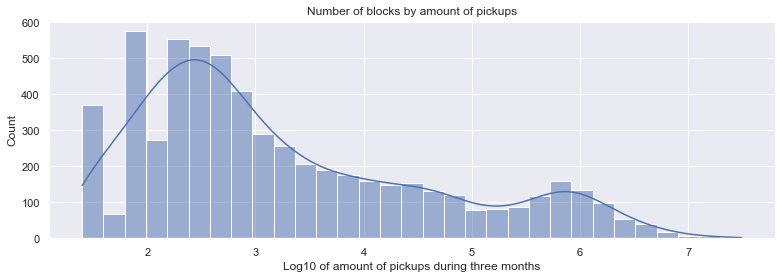

In [371]:
sns.set(rc={'figure.figsize':(13,4)})
ax = sns.histplot(np.log10(df.total), kde = True)
ax.set_title('Number of blocks by amount of pickups')
ax.set_xlabel('Log10 of amount of pickups during three months')
#ax.set_yscale("log")

# Data exploration

I present here some insights which I have found interesting when analyzing the dataset, and which can be relevant to start an Uber-like business in New York.

To start with, it is important to see which areas of New York are the ones with highest number of pickups. 
If we plot the pickup count data in a cartoframes map, we can quickly realize that **Manhattan seems to be the place to start the taxi business**, where the green areas indicate a high number of pickups. Grey areas are the blocks with no taxi pickups. The highest value is found at what I believe is the Empire State building block.

Outside of Manhattan, two big green blocks with a high number of pickups exist. They correspond to the **JFKennedy and La Guardia airports**, which makes a lot of sense since travellers are constantly coming into the city.

In [372]:
from cartoframes.auth import set_default_credentials
set_default_credentials('carto_creds.json')

In [373]:
pickup_count_map = pd.merge(nymap, df["total"], left_on = "geoid", right_index = True, how = "right").fillna(0)

In [375]:
from cartoframes.viz import Map, Layer, color_continuous_style, basic_style

Map([
    Layer(
        nymap,
        basic_style(
            color = "grey"
        )
    ),
    Layer(
        pickup_count_map,
        color_continuous_style(
            "total"
        )
    )
    ],
    widget = True
)

## Rush hours
Here we aggregate the number of pickups which happen **at each hour throughout the day** in our sample file.

We make this computation for **weekdays** and **weekends** separately.
* During the early morning hours (1-5 am) the traffic gets lower, but there is more on weekends since people go out.
* On weekdays the number of pickups spikes from 5 am onwards until 8: people go early to work
* Between 10-16 we observe very similar behaviours both for weekends and weekdays
* On weekends people sleep during the morning since they dont work

In [388]:
date_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]
sample = pd.read_csv("./sample_70000_clean.csv", index_col = 0, parse_dates=date_cols)

In [400]:
sample["pickup_hour"] = sample["tpep_pickup_datetime"].apply(lambda x : x.hour)
sample["is_weekend"] = sample["tpep_pickup_datetime"].apply(lambda x : x.weekday() in [5,6])

In [404]:
rush_hours_weekdays = sample[sample["is_weekend"] == False].groupby("pickup_hour").count()["VendorID"]
rush_hours_weekends = sample[sample["is_weekend"] == True].groupby("pickup_hour").count()["VendorID"]

Text(0.5, 1.0, 'Amount of pickups by hour')

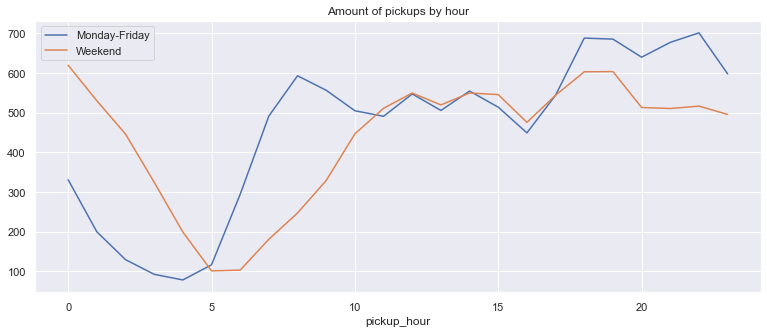

In [414]:
sns.set(rc={'figure.figsize':(13,5)})
sns.lineplot(x = rush_hours_weekdays.index, y = rush_hours_weekdays.values/5)
ax = sns.lineplot(x = rush_hours_weekends.index, y = rush_hours_weekends.values/2)
ax.legend(["Monday-Friday", "Weekend"])
ax.set_title('Amount of pickups by hour per day')

## Who is giving tips?
There are several possible explanations of people not giving tips:
* The ratio between the trip duration and the distance travelled is too high. This means that there was traffic or that the driver got lost (we are assumming we are almost always travelling in urban environment and not highways)
* When the traveller pays with card. When paying with cash it is easier to give a tip.
* If there is only one passenger it is easier to forget or to be sellfish.

Below we can check if there are relationships between this variables by plotting the correlation matrix

In [442]:
sample = sample[sample.trip_distance > 0]
sample["trip_minutes"] = (sample["tpep_dropoff_datetime"] - sample["tpep_pickup_datetime"]).apply(lambda x: x.seconds//60)
sample["duration_distance_ratio"] = sample["trip_minutes"]/sample["trip_distance"]
sample["pays_with_cash"] = sample["payment_type"] == 2
sample["alone"] = sample["passenger_count"] == 1

sample["gives_tip"] = sample["tip_amount"] > 0

In [452]:
tip_vars = ["gives_tip", "pays_with_cash", "alone", "duration_distance_ratio" ]
tips = sample[tip_vars]

There is very little or no correlation between any of the variables excepting **pays with cash**, which is **95%** inversely correlated with gives_tips. This is completely the opposite of what I expected

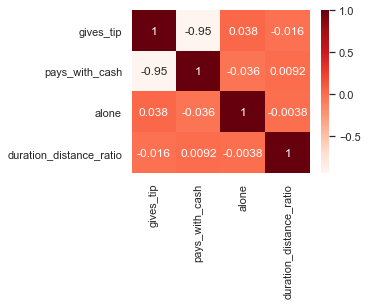

In [456]:
plt.figure(figsize=(4,3))
cor = tips.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

/Users/juanluisrto/opt/anaconda3/envs/carto/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


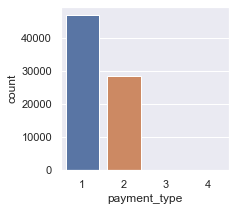

In [515]:
sns.set(rc={'figure.figsize':(3,3)})
ax = sns.countplot(sample["payment_type"])